[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


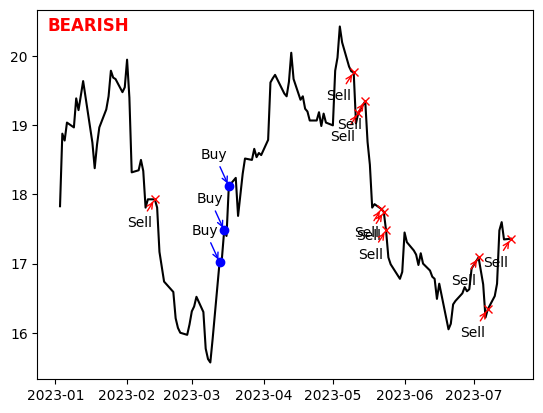

In [30]:
import tkinter as tk
from tkinter import messagebox, filedialog
from tkcalendar import DateEntry
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

trend = None  # Initialize the trend variable

def get_historical_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

def calculate_buy_sell_dates(data, volume_multiplier, sell_threshold):
    avg_volume = data['Volume'].mean()
    buy_dates = data[data['Volume'] > avg_volume * float(volume_multiplier)].index.tolist()
    try:
        sell_dates = data[data['Volume'] < avg_volume * float(sell_threshold)].index.tolist()
    except ValueError:
        sell_dates = []
    return buy_dates, sell_dates

def create_plot(data, buy_dates, sell_dates, trend):
    fig, ax = plt.subplots()
    ax.plot(data.index, data['Close'], 'k-', label='Close')

    # Plot buy dates as blue circles ('o')
    ax.plot(buy_dates, data.loc[buy_dates, 'Close'], 'bo')
    # Add labels for buy points
    for date in buy_dates:
        ax.annotate('Buy', xy=(date, data.loc[date, 'Close']), xytext=(-20, 20), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", color='blue'))

    # Plot sell dates as red crosses ('x')
    ax.plot(sell_dates, data.loc[sell_dates, 'Close'], 'rx')
    # Add labels for sell points
    for date in sell_dates:
        ax.annotate('Sell', xy=(date, data.loc[date, 'Close']), xytext=(-20, -20), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", color='red'))

    # Add trend identifier
    trend_text = 'BULLISH' if trend == 'Bullish' else 'BEARISH'
    ax.text(0.02, 0.95, trend_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left',
            fontsize=12, fontweight='bold', color='green' if trend == 'Bullish' else 'red')

    return fig, ax


def update_plot(ax, canvas, toolbar):
    # Clear the existing plot and toolbar
    ax.clear()
    canvas.draw()

    # Update the existing plot
    ax.plot(data.index, data['Close'], 'k-', label='Close')
    ax.plot(buy_dates, data.loc[buy_dates, 'Close'], 'bo')
    for date in buy_dates:
        ax.annotate('Buy', xy=(date, data.loc[date, 'Close']), xytext=(-20, 20), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", color='blue'))
    ax.plot(sell_dates, data.loc[sell_dates, 'Close'], 'rx')
    for date in sell_dates:
        ax.annotate('Sell', xy=(date, data.loc[date, 'Close']), xytext=(-20, -20), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", color='red'))

    # Add trend identifier
    if trend == 'Bullish':
        ax.text(0.02, 0.98, 'BULLISH', transform=ax.transAxes, color='green', fontsize=12, fontweight='bold', va='top')
    else:
        ax.text(0.02, 0.98, 'BEARISH', transform=ax.transAxes, color='red', fontsize=12, fontweight='bold', va='top')

    canvas.draw()

def clear_plot():
    global canvas, toolbar
    # Clear the existing plot and toolbar
    if canvas is not None:
        canvas.get_tk_widget().pack_forget()
        canvas = None
    if toolbar is not None:
        toolbar.pack_forget()
        toolbar = None

def calculate_summary_statistics(data):
    if data is not None:
        avg_volume = data['Volume'].mean()
        max_volume = data['Volume'].max()
        percentage_change = (data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0]
        fifty_two_week_range = f"{data['Close'].min()} - {data['Close'].max()}"
        daily_range = f"{data['Low'].min()} - {data['High'].max()}"
        all_time_high = data['Close'].max()
        all_time_low = data['Close'].min()

        summary_stats = {
            'Average Volume': avg_volume,
            'Max Volume': max_volume,
            'Percentage Change': percentage_change,
            '52-Week Range': fifty_two_week_range,
            'Daily Range': daily_range,
            'All-Time High': all_time_high,
            'All-Time Low': all_time_low
        }

        # Add arrows for volume comparison
        if avg_volume is not None and max_volume is not None:
            if avg_volume > max_volume:
                summary_stats['Volume'] = f"Below Average ↓"
            else:
                summary_stats['Volume'] = f"Above Average ↑"

        return summary_stats

def update_summary_statistics(summary_stats, trend):
    global summary_frame

    summary_frame.destroy()

    if summary_stats is not None:
        summary_frame = tk.LabelFrame(window, text="Summary Statistics", bd=1, relief=tk.SOLID)
        summary_frame.pack(pady=10, padx=10)

        row = 0
        for i, (stat, value) in enumerate(summary_stats.items()):
            key_label = tk.Label(summary_frame, text=f"{stat}:", font=('Arial', 12, 'normal'))
            key_label.grid(row=row, column=0, sticky='w')

            value_label = tk.Label(summary_frame, text=value, font=('Arial', 12, 'bold'))
            value_label.grid(row=row, column=1, sticky='w')

            help_button = tk.Button(summary_frame, text="Help", width=10, command=lambda s=stat: show_help(s))
            help_button.grid(row=row, column=2, sticky='w')

            row += 1

        # Add trend identifier
        trend_label = tk.Label(summary_frame, text="Trend:", font=('Arial', 12, 'normal'))
        trend_label.grid(row=row, column=0, sticky='w')

        trend_value = tk.Label(summary_frame, text=trend, font=('Arial', 12, 'bold'), fg='green' if trend == 'Bullish' else 'red')
        trend_value.grid(row=row, column=1, sticky='w')


def plot_asset_data():
    global data, buy_dates, sell_dates, summary_stats, canvas, toolbar, trend

    symbol = symbol_entry.get()
    start_date = start_date_entry.get_date().strftime('%Y-%m-%d')
    end_date = end_date_entry.get_date().strftime('%Y-%m-%d')
    volume_multiplier = volume_multiplier_entry.get()
    sell_threshold = sell_threshold_entry.get()

    try:
        # Download data from Yahoo Finance
        data = get_historical_data(symbol, start_date, end_date)

        # Find buy and sell dates
        buy_dates, sell_dates = calculate_buy_sell_dates(data, volume_multiplier, sell_threshold)

        # Calculate and display the summary statistics
        summary_stats = calculate_summary_statistics(data)
        update_summary_statistics(summary_stats, trend)

        # Determine the trend based on the closing prices
        if data['Close'].iloc[-1] > data['Close'].iloc[0]:
            trend = 'Bullish'
        else:
            trend = 'Bearish'

        # Create or update the plot with the trend identifier
        if canvas is None:
            # Create a new plot
            fig, ax = create_plot(data, buy_dates, sell_dates, trend)
            canvas = FigureCanvasTkAgg(fig, master=plot_frame)
            canvas.get_tk_widget().pack()
            toolbar = NavigationToolbar2Tk(canvas, plot_frame)
            toolbar.pack()
        else:
            # Update the existing plot
            ax = canvas.figure.axes[0]
            update_plot(ax, canvas, toolbar)

    except Exception as e:
        messagebox.showerror("Error", str(e))

def export_data():
    global data
    if data is not None:
        file_path = filedialog.asksaveasfilename(defaultextension=".csv")
        if file_path:
            data.to_csv(file_path, index=False)
            messagebox.showinfo("Export Successful", "Data exported successfully.")
    else:
        messagebox.showwarning("Export Failed", "No data available to export.")

def show_help(statistic):
    help_text = ''
    if statistic == 'Average Volume':
        help_text = "Average Volume shows how much trading activity occurs on average for the selected stock. A higher average volume generally indicates more active trading."
    elif statistic == 'Max Volume':
        help_text = "Max Volume represents the highest trading volume reached during the selected period. It helps to identify the day with the most trading activity."
    elif statistic == 'Percentage Change':
        help_text = "Percentage Change measures the change in the stock's price from the start date to the end date, expressed as a percentage. It shows how much the stock's value has increased or decreased over time."
    elif statistic == '52-Week Range':
        help_text = "52-Week Range displays the lowest and highest prices that the stock has reached during the past 52 weeks. It helps to understand the stock's price movement over a longer period."
    elif statistic == 'Daily Range':
        help_text = "Daily Range shows the lowest and highest prices that the stock has reached within the selected period. It provides insights into the stock's price fluctuations on a daily basis."
    elif statistic == 'All-Time High':
        help_text = "All-Time High represents the highest price that the stock has ever reached within the selected period. It shows the stock's highest value recorded so far."
    elif statistic == 'All-Time Low':
        help_text = "All-Time Low represents the lowest price that the stock has ever reached within the selected period. It shows the stock's lowest value recorded so far."

    messagebox.showinfo("Help", help_text)


# Create the main window
window = tk.Tk()
window.title("Asset Data Visualization")

# Create a frame for user inputs
inputs_frame = tk.Frame(window)
inputs_frame.pack(pady=10)

# Create labels and entry fields for user inputs
symbol_label = tk.Label(inputs_frame, text="Symbol:")
symbol_label.pack(side=tk.LEFT)
symbol_entry = tk.Entry(inputs_frame)
symbol_entry.pack(side=tk.LEFT, padx=5)

start_date_label = tk.Label(inputs_frame, text="Start Date:")
start_date_label.pack(side=tk.LEFT)
start_date_entry = DateEntry(inputs_frame, date_pattern="yyyy-mm-dd")
start_date_entry.pack(side=tk.LEFT, padx=5)

end_date_label = tk.Label(inputs_frame, text="End Date:")
end_date_label.pack(side=tk.LEFT)
end_date_entry = DateEntry(inputs_frame, date_pattern="yyyy-mm-dd")
end_date_entry.pack(side=tk.LEFT, padx=5)

volume_multiplier_label = tk.Label(inputs_frame, text="Volume Multiplier:")
volume_multiplier_label.pack(side=tk.LEFT)
volume_multiplier_entry = tk.Entry(inputs_frame)
volume_multiplier_entry.pack(side=tk.LEFT, padx=5)

sell_threshold_label = tk.Label(inputs_frame, text="Sell Threshold:")
sell_threshold_label.pack(side=tk.LEFT)
sell_threshold_entry = tk.Entry(inputs_frame)
sell_threshold_entry.pack(side=tk.LEFT, padx=5)

# Create a frame for buttons
button_frame = tk.Frame(window)
button_frame.pack(pady=10)

# Create a button to trigger data download and plot
plot_button = tk.Button(button_frame, text="Plot", width=10, command=plot_asset_data)
plot_button.pack(side=tk.LEFT, padx=5)

# Create a button to clear the plot and toolbar
clear_button = tk.Button(button_frame, text="Clear", width=10, command=clear_plot)
clear_button.pack(side=tk.LEFT, padx=5)

# Create a button to export data
export_button = tk.Button(button_frame, text="Export Data", width=12, command=export_data)
export_button.pack(side=tk.LEFT, padx=5)

# Create a frame for the plot and summary statistics
plot_summary_frame = tk.Frame(window)
plot_summary_frame.pack(pady=10)

# Create a frame for the plot
plot_frame = tk.Frame(plot_summary_frame)
plot_frame.pack(side=tk.LEFT)

# Create a canvas and toolbar for the plot
canvas = None
toolbar = None

# Create a label frame for the summary statistics
summary_frame = tk.LabelFrame(plot_summary_frame, text="Summary Statistics", bd=1, relief=tk.SOLID)
summary_frame.pack(pady=10, padx=10)

# Run the main event loop
window.mainloop()
